# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import src.edhec_risk_kit as erk
import portfolio_design.src.analysis as an

from scipy import stats
from src import data


ix = pd.IndexSlice

%matplotlib inline

# Assets

In [236]:
asset_symbols = [
  'SOXX',
  'DHR',
  'COST',
#   'AC'
]

## Market Data

In [237]:
asset_market_data_df = (
  data
    .get_monthly_market_data(asset_symbols, interval = '1mo')
)

[*********************100%***********************]  3 of 3 completed


/Users/calvindelima/projects/investing/.venv/lib/python3.9/site-packages/pandas/core/generic.py:4152: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



## Returns Data

In [446]:
# TODO: Columns insted of dataframes

asset_1mo_returns_df = data.compute_monthly_returns_from_mmd(asset_market_data_df)
asset_1mo_returns_df.index = asset_1mo_returns_df.index + pd.DateOffset(months = -1)
asset_2mo_returns_df = data.compute_monthly_returns_from_mmd(asset_market_data_df)
asset_2mo_returns_df.index = asset_2mo_returns_df.index + pd.DateOffset(months = -2)
asset_3mo_returns_df = data.compute_period_returns_from_mmd(asset_market_data_df, periods = 3)
asset_3mo_returns_df.index = asset_3mo_returns_df.index + pd.DateOffset(months = -3)
asset_6mo_returns_df = data.compute_period_returns_from_mmd(asset_market_data_df, periods = 6)
asset_6mo_returns_df.index = asset_6mo_returns_df.index + pd.DateOffset(months = -6)
asset_12mo_returns_df = data.compute_period_returns_from_mmd(asset_market_data_df, periods = 12)
asset_12mo_returns_df.index = asset_12mo_returns_df.index + pd.DateOffset(months = -12)
asset_24mo_returns_df = data.compute_period_returns_from_mmd(asset_market_data_df, periods = 24)
asset_24mo_returns_df.index = asset_24mo_returns_df.index + pd.DateOffset(months = -24)

data.compute_period_returns_from_mmd(asset_market_data_df, periods = 24)

,COST,DHR,SOXX
date,,,
1985-01-01,NaN,NaN,NaN
1985-02-01,NaN,NaN,NaN
1985-03-01,NaN,NaN,NaN
1985-04-01,NaN,NaN,NaN
1985-05-01,NaN,NaN,NaN
...,...,...,...
2020-12-01,0.883619,1.175270,1.480602
2021-01-01,0.716048,1.163532,1.326490
2021-02-01,0.581418,0.744966,1.328970


In [239]:
# (
#   r1_df
#     .melt(
#       ignore_index = False,
#       var_name = 'Asset',
#       value_name = 'Return'
#     )
#     .assign(period = '1 Month')
# )

# Prices

In [240]:
def plot_closing_prices(returns_df: pd.DataFrame):
  long_df = (
    returns_df['close']
      .reset_index()
      .assign(
        period = lambda df: df['date'].apply(
          lambda d: 'pre-covid' if d <= pd.to_datetime('2020-03-01') else 'post-covid'
        )
      )
      .melt(
        id_vars = ['date', 'period'], 
        var_name = 'ticker', 
        value_name = 'price',
      )
  )

  sns.relplot(
    x = 'date',
    y = 'price',
    kind = 'line',
    col = 'ticker',
    hue = 'period',
    data = long_df,
    col_wrap = 4,
    facet_kws = {'sharey': False}
  );

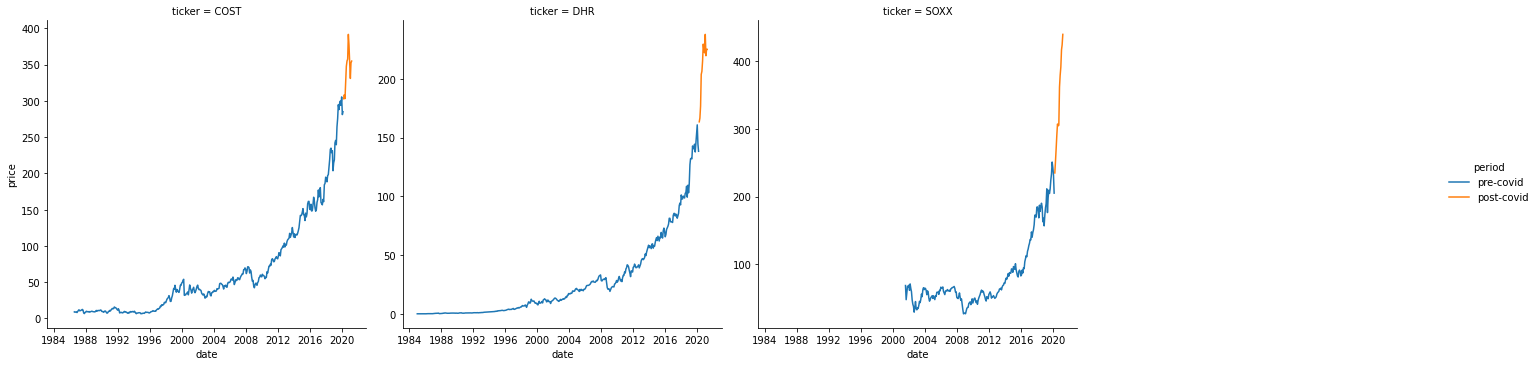

In [241]:
plot_closing_prices(asset_market_data_df)

# Return Time Series

In [242]:
def summarize_return_statistics(
  returns_df: pd.DataFrame,
  as_of: str = None):
  
  display_df = returns_df.copy()
  
  if as_of is not None:
    display_df = display_df.loc[as_of:]
  
  display(
    display_df
      .describe()
      .T
      .sort_values('mean', ascending = False)
      .assign(years = lambda df: df['count'] / 12)
      .style
      .bar(subset = ['mean', 'std'])
  )

In [243]:
def plot_returns(
  returns_df: pd.DataFrame,
  as_of: str = None):
  
  display_df = returns_df.copy()
  
  if as_of is not None:
    display_df = display_df.loc[as_of:]
    
  long_df = (
    display_df
      .reset_index()
      .assign(
        period = lambda df: df['date'].apply(
          lambda d: 'pre-covid' if d <= pd.to_datetime('2020-03-01') else 'post-covid'
        )
      )
      .melt(id_vars = ['date', 'period'], var_name = 'ticker', value_name = 'return')
  )

  f = sns.relplot(
    x = 'date',
    y = 'return',
    kind = 'line',
    col = 'ticker',
    hue = 'period',
    data = long_df,
    col_wrap = 4
  );

  f.map(plt.axhline, y = 0, ls = '--', color = 'darkgrey');

## 3 Months

In [244]:
summarize_return_statistics(asset_3mo_returns_df)

,count,mean,std,min,25%,50%,75%,max,years
DHR,433.000000,0.064715,0.155004,-0.475982,-0.014919,0.055212,0.129519,0.888888,36.083333
COST,414.000000,0.039080,0.137525,-0.460000,-0.036167,0.045346,0.118993,0.523747,34.500000
SOXX,234.000000,0.037531,0.134823,-0.448227,-0.030512,0.050875,0.119812,0.386861,19.500000


In [245]:
summarize_return_statistics(asset_3mo_returns_df, as_of = '2010-01-01')

,count,mean,std,min,25%,50%,75%,max,years
DHR,136.000000,0.062500,0.106634,-0.208232,-0.004731,0.046000,0.106468,0.600062,11.333333
SOXX,136.000000,0.059276,0.101077,-0.186489,0.008433,0.068604,0.118725,0.324511,11.333333
COST,136.000000,0.049393,0.076500,-0.132986,-0.001052,0.044626,0.106359,0.233642,11.333333


In [246]:
summarize_return_statistics(asset_3mo_returns_df, as_of = '2015-01-01')

,count,mean,std,min,25%,50%,75%,max,years
DHR,76.000000,0.074408,0.119746,-0.097188,-0.004731,0.042630,0.110129,0.600062,6.333333
SOXX,76.000000,0.071402,0.103718,-0.179864,0.021575,0.073871,0.129970,0.324511,6.333333
COST,76.000000,0.046712,0.084046,-0.132986,-0.005644,0.039690,0.108171,0.233642,6.333333


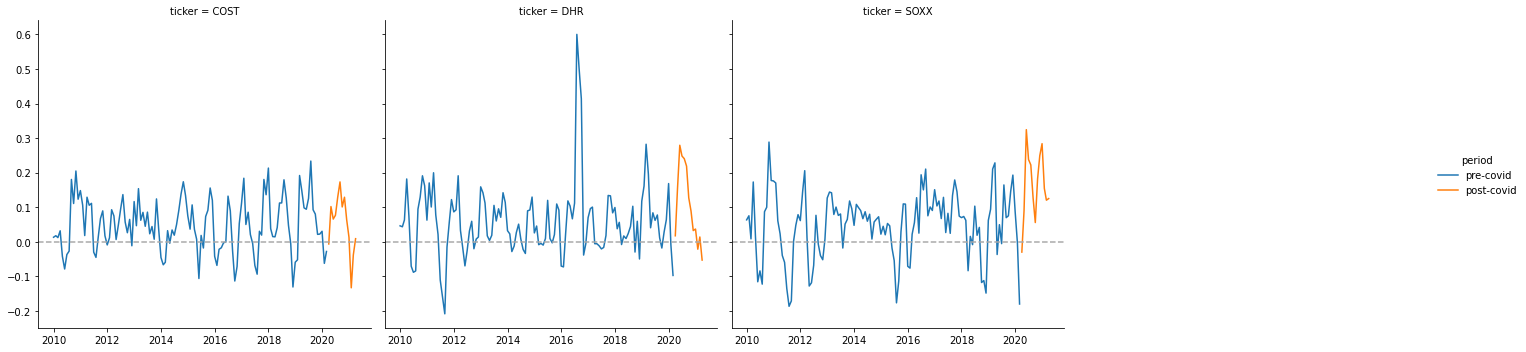

In [247]:
plot_returns(asset_3mo_returns_df, as_of = '2010-01-01')

## 12 Months

In [248]:
summarize_return_statistics(asset_12mo_returns_df)

,count,mean,std,min,25%,50%,75%,max,years
DHR,424.000000,0.262881,0.276987,-0.358158,0.099260,0.239823,0.380023,1.988230,35.333333
COST,405.000000,0.152025,0.262932,-0.515748,0.011496,0.163575,0.283139,1.059829,33.750000
SOXX,225.000000,0.150161,0.306641,-0.540526,-0.047731,0.141783,0.359042,1.089520,18.750000


In [249]:
summarize_return_statistics(asset_12mo_returns_df, as_of = '2010-01-01')

,count,mean,std,min,25%,50%,75%,max,years
DHR,136.000000,0.274555,0.192784,-0.045116,0.135239,0.223684,0.378009,0.881468,11.333333
SOXX,136.000000,0.248593,0.226982,-0.149500,0.060148,0.265838,0.398739,1.089520,11.333333
COST,136.000000,0.219451,0.112892,-0.059849,0.154168,0.222173,0.289472,0.504931,11.333333


In [250]:
summarize_return_statistics(asset_12mo_returns_df, as_of = '2015-01-01')

,count,mean,std,min,25%,50%,75%,max,years
DHR,76.000000,0.324465,0.221753,0.029169,0.146807,0.247716,0.463417,0.881468,6.333333
SOXX,76.000000,0.287282,0.247459,-0.116511,0.081642,0.279482,0.434602,1.089520,6.333333
COST,76.000000,0.212133,0.116940,-0.059849,0.154168,0.213169,0.287222,0.504931,6.333333


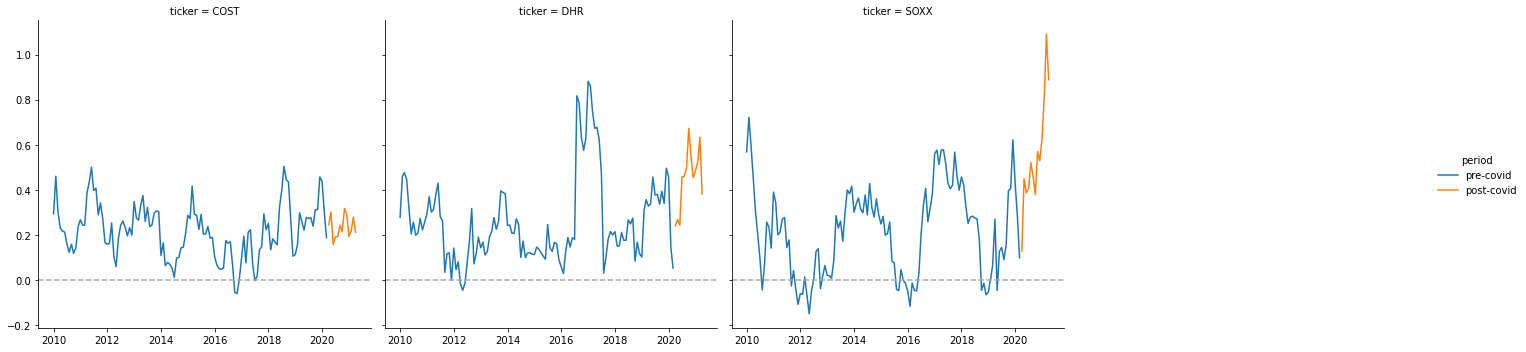

In [251]:
plot_returns(asset_12mo_returns_df, as_of = '2010-01-01')

## 24 Months

In [252]:
summarize_return_statistics(asset_24mo_returns_df)

,count,mean,std,min,25%,50%,75%,max,years
DHR,412.000000,0.578288,0.470038,-0.289743,0.286752,0.492898,0.829131,2.873423,34.333333
COST,393.000000,0.336145,0.482525,-0.472973,-0.029837,0.289655,0.509672,2.314478,32.750000
SOXX,213.000000,0.302848,0.408931,-0.566211,0.020474,0.258513,0.510411,1.480602,17.750000


TODO: Compare to a monthly interest rate

In [253]:
summarize_return_statistics(asset_24mo_returns_df, as_of = '2010-01-01')

,count,mean,std,min,25%,50%,75%,max,years
DHR,136.000000,0.550778,0.314279,-0.105654,0.337511,0.495779,0.783780,1.331854,11.333333
SOXX,136.000000,0.475892,0.367781,-0.170604,0.217076,0.389978,0.678518,1.480602,11.333333
COST,136.000000,0.439155,0.220729,-0.197471,0.344482,0.469955,0.569775,0.922372,11.333333


In [254]:
summarize_return_statistics(asset_12mo_returns_df, as_of = '2015-01-01')

,count,mean,std,min,25%,50%,75%,max,years
DHR,76.000000,0.324465,0.221753,0.029169,0.146807,0.247716,0.463417,0.881468,6.333333
SOXX,76.000000,0.287282,0.247459,-0.116511,0.081642,0.279482,0.434602,1.089520,6.333333
COST,76.000000,0.212133,0.116940,-0.059849,0.154168,0.213169,0.287222,0.504931,6.333333


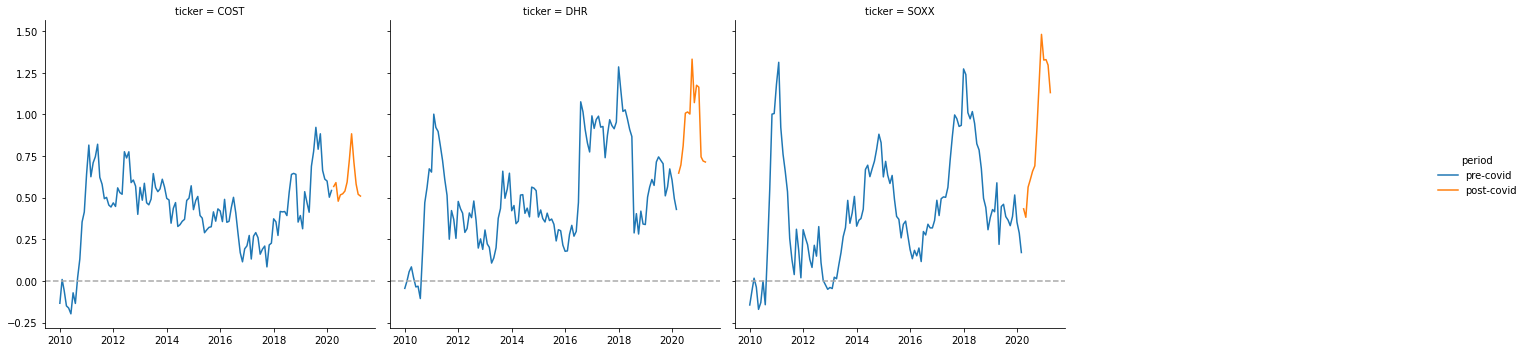

In [255]:
plot_returns(asset_24mo_returns_df, as_of = '2010-01-01')

# Correlations

In [256]:
def plot_correlation_matrix(returns_df: pd.DataFrame, as_of: str):
  display_df = returns_df.copy()
  
  if as_of is not None:
    display_df = display_df.loc[as_of:]
  
  plt.figure(figsize = (7, 5))
  sns.heatmap(display_df.corr(), annot = True)

## 3 Months

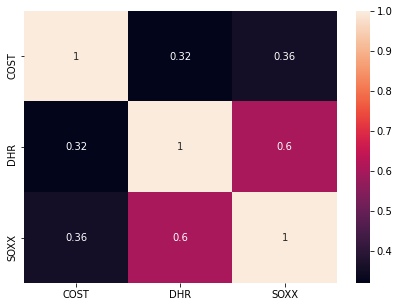

In [257]:
plot_correlation_matrix(asset_3mo_returns_df, '2010-01-01')

## 12 Months

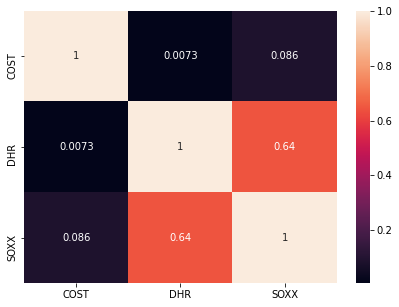

In [258]:
plot_correlation_matrix(asset_12mo_returns_df, '2010-01-01')

## 24 Months

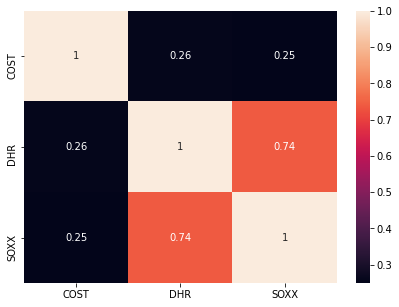

In [259]:
plot_correlation_matrix(asset_24mo_returns_df, '2010-01-01')

In [260]:
def plot_return_distributions(returns_df: pd.DataFrame, as_of: str):
  display_df = returns_df.copy()
  
  if as_of is not None:
    display_df = display_df.loc[as_of:]
    
  long_df = (
    display_df
      .reset_index()
      .assign(
        period = lambda df: df['date'].apply(
          lambda d: 'pre-covid' if d <= pd.to_datetime('2020-03-01') else 'post-covid'
        )
      )
      .melt(id_vars = ['date', 'period'], var_name = 'ticker', value_name = 'return')
  )

  f = sns.FacetGrid(
    data = long_df,
    col = 'ticker',
    #hue = 'period',
    sharey = False,
    col_wrap = 4
  )
  
  display(long_df[~long_df.isnull()]['ticker'].value_counts())

  f.map(sns.histplot, 'return');
  f.map(plt.axvline, x=0, color = 'darkred')

# Return Distributions

## 3 Months

SOXX    136
COST    136
DHR     136
Name: ticker, dtype: int64

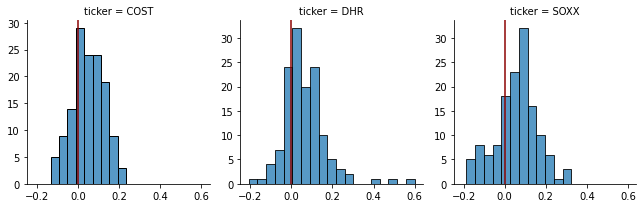

In [261]:
plot_return_distributions(asset_3mo_returns_df, '2010-01-01')

## 6 Months

SOXX    136
COST    136
DHR     136
Name: ticker, dtype: int64

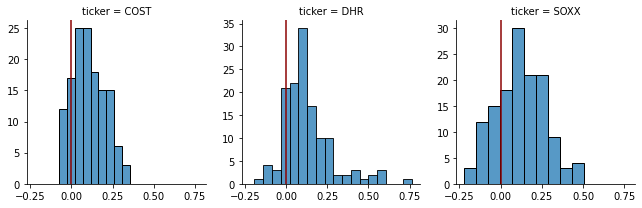

In [262]:
plot_return_distributions(asset_6mo_returns_df, '2010-01-01')

## 24 Months

SOXX    136
COST    136
DHR     136
Name: ticker, dtype: int64

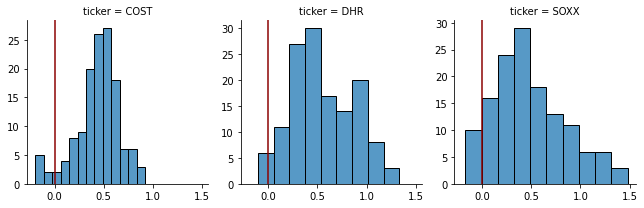

In [263]:
plot_return_distributions(asset_24mo_returns_df, '2010-01-01')

# Portfolio

In [451]:
weighted_returns_as_of = '2010-01-01'
asset_1mo_returns_period_df = asset_1mo_returns_df.loc[weighted_returns_as_of:, ]
asset_2mo_returns_period_df = asset_2mo_returns_df.loc[weighted_returns_as_of:, ]
asset_3mo_returns_period_df = asset_3mo_returns_df.loc[weighted_returns_as_of:, ]
asset_6mo_returns_period_df = asset_6mo_returns_df.loc[weighted_returns_as_of:, ]
asset_12mo_returns_period_df = asset_12mo_returns_df.loc[weighted_returns_as_of:, ]
asset_24mo_returns_period_df = asset_24mo_returns_df.loc[weighted_returns_as_of:, ]

## Time Series

In [ ]:
returns = (
  (1 / 4 * asset_24mo_returns_period_df)
    .sum(axis = 1)
    .rename('Weighted Return')
)
rolling_returns = (
  returns
    .rolling(3)
    .mean()
    .rename('Rolling Weighted Return')
    .shift(-2)
)
plot_df = (
  pd
    .concat([returns, rolling_returns], axis = 1)
    .reset_index()
    .melt(
      id_vars = 'date',
      value_name = 'Return',
      var_name = 'Return Type'
    )
)
print('Number of observations:', len(returns))

px.line(
  plot_df, 
  x = 'date', 
  y = 'Return', 
  color = 'Return Type'
)

Number of observations: 112


We use the smoothed line to "predict" what regime we are on based on the rolling 6-year average. Probably best to pull the trigger now.

Number of observations: 133


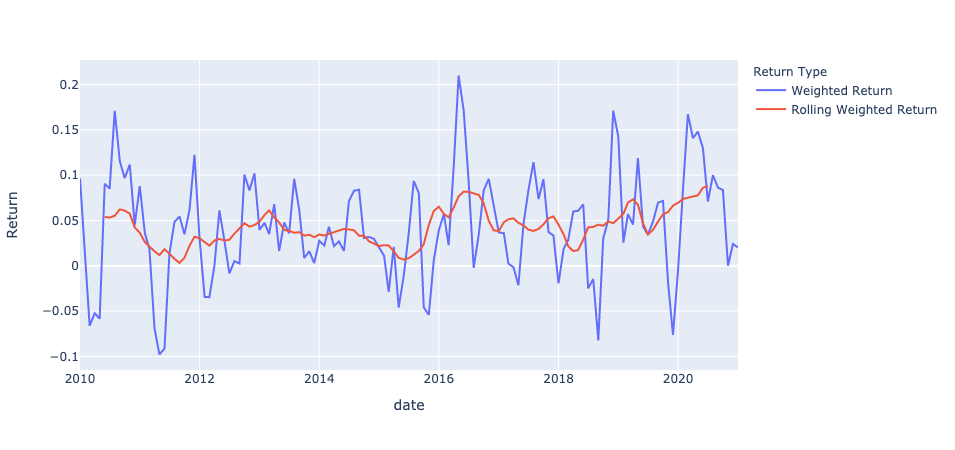

In [468]:
returns = (
  (1 / 4 * asset_3mo_returns_period_df)
    .sum(axis = 1)
    .rename('Weighted Return')
)
rolling_returns = (
  returns
    .rolling(12)
    .mean()
    .rename('Rolling Weighted Return')
    .shift(-6)
)
plot_df = (
  pd
    .concat([returns, rolling_returns], axis = 1)
    .reset_index()
    .melt(
      id_vars = 'date',
      value_name = 'Return',
      var_name = 'Return Type'
    )
)
print('Number of observations:', len(returns))

px.line(
  plot_df, 
  x = 'date', 
  y = 'Return', 
  color = 'Return Type'
)

## Expected Return

In [395]:
n_assets = len(asset_symbols)
equal_weights = np.repeat(1 / n_assets, n_assets)
asset_annualized_returns = erk.annualize_rets(asset_1mo_return_period_df, periods_per_year = 24)

equal_weight_annualized_portfolio_return = erk.portfolio_return(
  equal_weights,
  asset_annualized_returns
)

r = equal_weight_annualized_portfolio_return
print('Equally Weighted Annualized Portfolio Return', round(r, 2))

Equally Weighted Annualized Portfolio Return 0.53


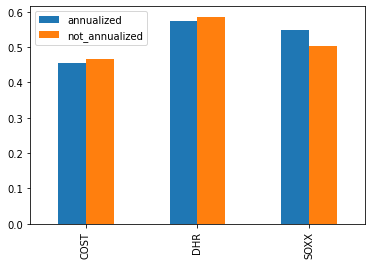

In [421]:
pd.concat([
  asset_annualized_returns.rename('annualized'),
  asset_24mo_returns_period_df.mean().rename('not_annualized')
], axis = 1).plot.bar();

So we can more or less treat annualized returns as not annualized returns.

In [420]:
asset_annualized_returns

COST    0.455405
DHR     0.572758
SOXX    0.547155
dtype: float64

In [415]:
asset_24mo_returns_period_df.mean()

COST    0.466494
DHR     0.586156
SOXX    0.503032
dtype: float64

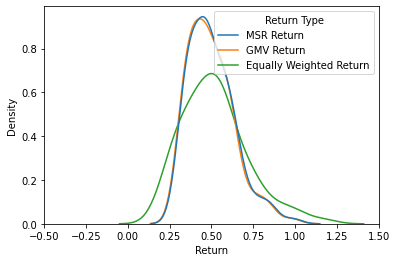

In [394]:
sns.kdeplot(data = portfolio_returns_long_df, x = 'Return', hue = 'Return Type');
plt.xlim(-0.5, 1.5);

<AxesSubplot:ylabel='Density'>

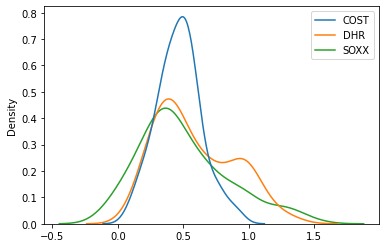

In [392]:
sns.kdeplot(data = asset_24mo_returns_period_df)

## Weights

EW Weights: [0.33333333 0.33333333 0.33333333]
EW Return: 0.53
MSR Weights: [0.68449562 0.2765573  0.03894708]
MSR Return: 0.49
GMV Weights: [0.71874926 0.23871065 0.04254008]
GMV Return: 0.49


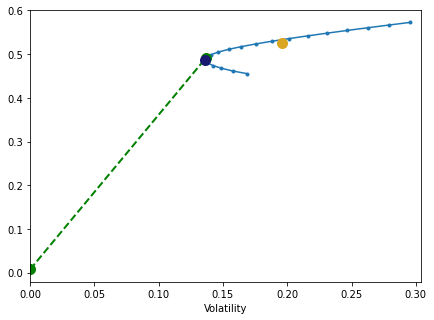

In [397]:
asset_cov = asset_24mo_returns_period_df.cov()
erk.plot_ef(
  20, 
  asset_annualized_returns, 
  asset_cov,
  show_cml = True,
  show_gmv = True,
  show_ew = True,
  riskfree_rate = 0.0075
);

## Backtest

In [387]:
                        # COST        DHR         SOXX
msr_weights = np.array([0.68449562, 0.2765573,  0.03894708])
gmv_weights = np.array([0.71874926, 0.23871065, 0.04254008])
ew_weights = equal_weights

Number of observations: 124


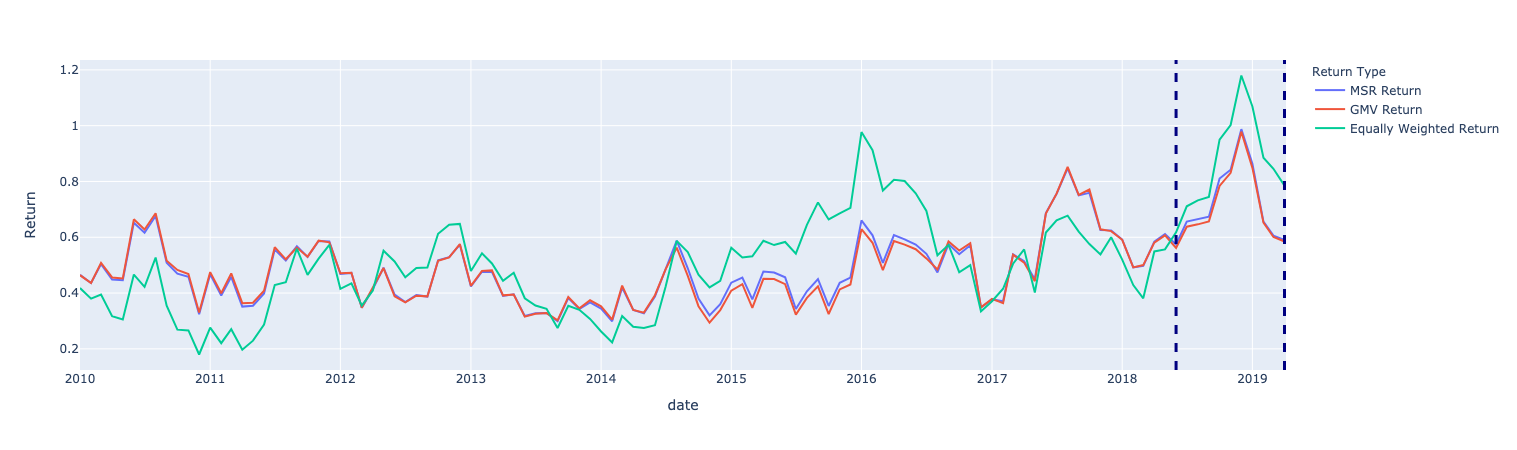

In [407]:
msr_returns = (
  (msr_weights.T * asset_24mo_returns_period_df).sum(axis = 1)
    .rename('MSR Return')
)
gmv_returns = (
  (gmv_weights.T * asset_24mo_returns_period_df).sum(axis = 1)
    .rename('GMV Return')
)
ew_returns = (
  (ew_weights.T * asset_24mo_returns_period_df).sum(axis = 1)
    .rename('Equally Weighted Return')
)
portfolio_returns_df = (
  pd
    .concat([
        msr_returns, 
        gmv_returns,
        ew_returns
      ], axis = 1
    )
)

portfolio_returns_long_df = (
  portfolio_returns_df
    .reset_index()
    .melt(
      id_vars = 'date',
      value_name = 'Return',
      var_name = 'Return Type'
    )
)

print('Number of observations:', len(returns))

f = px.line(
  portfolio_returns_long_df, 
  x = 'date', 
  y = 'Return', 
  color = 'Return Type'
)
f.add_vline(
  x='2018-06-01', 
  line_width=3, 
  line_dash="dash",
  line_color="navy")
f.add_vline(
  x='2019-04-01', 
  line_width=3, 
  line_dash="dash",
  line_color="navy")

Started a regime change in June 2018, which looks like it may be reverting back to similar returns as MSR and GMV portfolios.

In [359]:
asset_24mo_returns_period_df.apply(erk.cvar_historic)

COST   -0.142061
DHR    -0.165077
SOXX    0.023831
dtype: float64

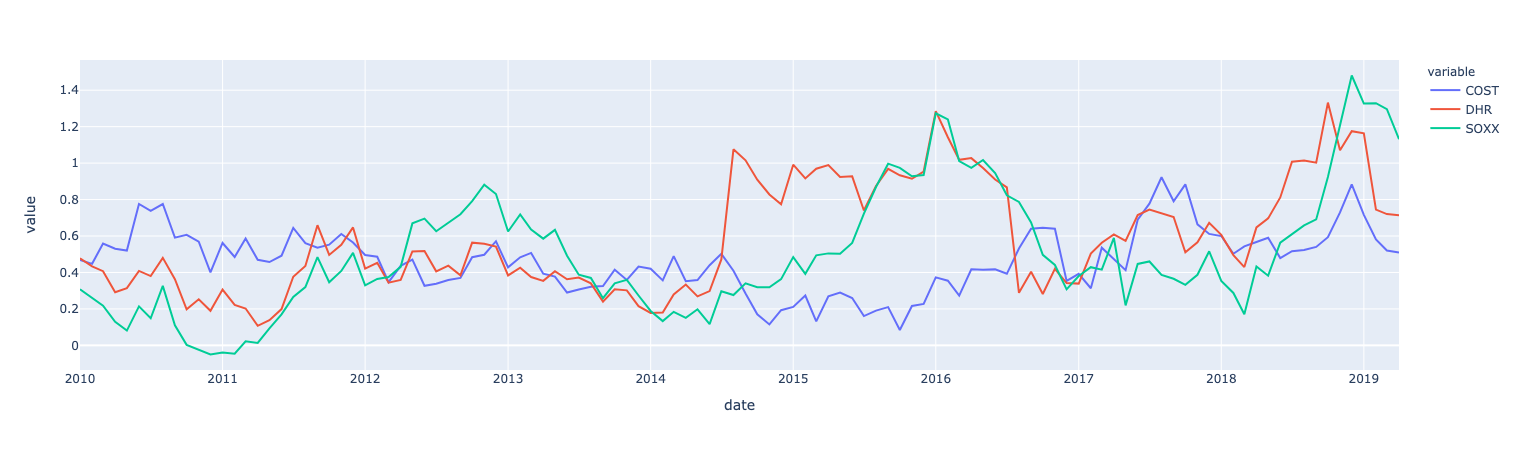

In [423]:
px.line(asset_24mo_returns_period_df)

DHR by itself has lots of upside and so does SOXX, but there is less diversity.

In [425]:
portfolio_returns_df.apply(erk.cvar_historic)

MSR Return                -0.314514
GMV Return                -0.310674
Equally Weighted Return   -0.218634
dtype: float64

In [359]:
asset_24mo_returns_period_df.apply(erk.cvar_historic)

COST   -0.142061
DHR    -0.165077
SOXX    0.023831
dtype: float64

In [360]:
portfolio_returns_df.apply(erk.cvar_historic)

MSR Return                -0.314514
GMV Return                -0.310674
Equally Weighted Return   -0.218634
dtype: float64

Equally Weighted Return    112
Name: ticker, dtype: int64

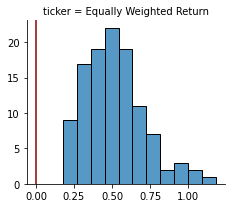

In [430]:
plot_return_distributions(portfolio_returns_df['Equally Weighted Return'], '2010-01-01')

MSR Return    135
Name: ticker, dtype: int64

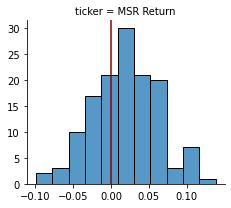

In [440]:
plot_return_distributions(
  (
    (msr_weights.T * asset_1mo_returns_period_df).sum(axis = 1)
      .rename('MSR Return')
  ),
  as_of = '2010-01-01'
)

MSR Return    124
Name: ticker, dtype: int64

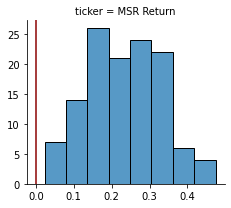

In [442]:
plot_return_distributions(
  (
    (msr_weights.T * asset_12mo_returns_period_df).sum(axis = 1)
      .rename('MSR Return')
  ),
  as_of = '2010-01-01'
)